# Histopathologic Cancer Detection Project

4/3/2024

The following data analysis outlines __a method for Histopathologic cancer detection in images of cellular membrane/cells__ using convolutional neural networks.  The problem statement is officially provided by the host on Kaggle.  

The analysis begins with an __exploratory data analysis procedure.__  The __data is first examined__ for important characteristics, such as image size.  It is then __cleaned by confirming/removing duplicates and blank images.__  Finally, broader characteristics such as __brightness, feature complexity, and pixel statistics__ were observed/recorded.  Conclusions from the EDA procedure were used to __develop image data generators__ for training purposes and influenced model architecture decisions.

The __convolutional neural network architectures__ studied were __inceptionV3, Xception, and a completely new/custom model.__  InceptionV3 is a classic architecture discussed frequently in literature utilizing 'inception' units for feature extraction.  Xception is similar, but has been seen to perform better in image classification tasks.  Both inceptionV3 and Xception were not retrained and both were used in __transfer learning__ at particular layers, whose outputs were then passed to __custom CNN additions.__  Finally, a purely custom CNN was developed for comparison both in terms of __accuracy and computational weight/training time.__
    
Data Source: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data
 
__Table of Contents:__

Part 1: Exploratory Data Analysis.

Part 2: Model Training

Part 3: Conclusion

## Part 1: Exploratory Data Analysis

To begin the data analysis process, I started with an EDA procedure.  I looked at the __type of data present__ in the train and test folders.  I looked out the __sizes of the images__ and the __amount of images present.__  I also checked for __duplicates and blank images.__

After looking at the data as a whole, I began examining positive and negative cancer images for specific characteristics.  I output some __example positive and negative pictures__ and inspected them visually in order to determine what kinds of objects or features might lead to distinguishing characteristics.  I focused on __brightness and RGB values__ in order to try to figure out if __low level features__ might play a role in identifying positive vs negative cancer images.  I determined whether or not there were substantial differences between typical positive and negative images in brightness and RBG values.

My most important find turned out to be how __difficult__ it was to distinguish positive vs negative cancer images. I decided that this was due to the fact that there were most likely __underlying primative features__ that were difficult to distinguish, but might lead to a positive or negative identification.  I made the general assessment that the __data was highly variant and contained low level features/objects.__

Finally, considering my results I developed __two image data generators.__  One with __large batch sizes and few epochs__ and the other with __small batch sizes and many epochs.__  I wanted to confirm my theory that __small batch sizes and many epochs would lead to a more generalizable model__ and higher global accuracies amidst such a highly variant dataset.

### Discussion

Import libraries.

In [345]:
import os
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

### Discussion

__Stored references (path and id) to data__ in dataframe.  Found storing image numpy arrays in dataframe to be computationally obsolete, used flow_from_directory and image data generators for training. __Examined test and train sets.__ Appended labels to end of dataframe. 

In [157]:
base_dir = '../histopathologic_cancer_detection'
train_dir = 'train'
pathList = []
nameList = []


for filename in os.listdir(train_dir):
    f = os.path.join(train_dir, filename)

    if os.path.isfile(f):
        nameList.append(filename.split('.')[0])
        pathList.append(base_dir + '/' + train_dir + '/' + filename)

df = pd.DataFrame(data={'Path': pathList, 'id': nameList})
label_path = os.path.join(base_dir, 'train_labels.csv')

train_labels = pd.read_csv(label_path)

df = df.merge(train_labels, on = "id")
df.head()

,Path,id,label
0,../histopathologic_cancer_detection/train/0000...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,../histopathologic_cancer_detection/train/0000...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,../histopathologic_cancer_detection/train/0000...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,../histopathologic_cancer_detection/train/0000...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,../histopathologic_cancer_detection/train/0000...,0000da768d06b879e5754c43e2298ce48726f722,1


In [291]:
test_dir = 'test'
pathList = []
nameList = []

for filename in os.listdir(test_dir):
    f = os.path.join(test_dir, filename)
    if os.path.isfile(f):
        nameList.append(filename.split('.')[0])
        pathList.append(test_dir + '/' + filename)

df_test = pd.DataFrame(data={'Path': pathList, 'id': nameList})

df_test.head()

,Path,id
0,test/00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,test/000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


### Discussion

Examined the __number of images__ in the training data set and test data set.  Found there were around 220000 training images and 1588 test images.  Examined training set for __blank images and duplicates.__  Found there were none and moved on.

In [302]:
print('df shape',df.shape)
print('nulls :',df.isnull().sum().sum())
print("dups: ",df.duplicated().sum())

print(' ')

print('df Test shape',dfTest.shape)
print('nulls :',dfTest.isnull().sum().sum())
print("dups: ",dfTest.duplicated().sum())

df shape (220025, 3)
nulls : 0
dups:  0
 
df Test shape (1588, 2)
nulls : 0
dups:  0


### Discussion

Examined the __number of positive and negative cancer images__ in training data set.  Found they were on the same order, but there were about 40,000 more negative images than positive images.  Even so, I believed neither class to be over or under represented.

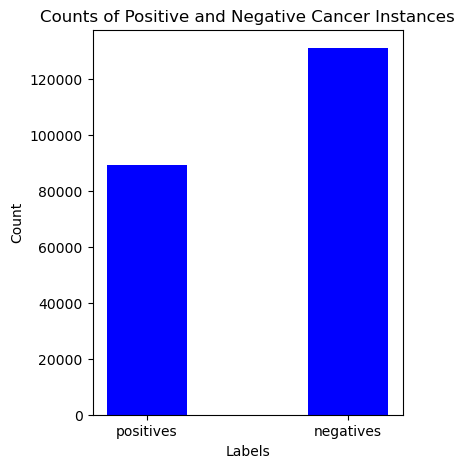

In [303]:
# Generate Bar Graph
positives = (df['label'] == 1).sum()
negatives = (df['label'] == 0).sum()

data = {'positives':positives, 'negatives':negatives}
labels = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (4, 5))
plt.bar(labels, values, color ='blue',width = 0.4)
 
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Counts of Positive and Negative Cancer Instances")
plt.show()

### Discussion

Output some __example positive and negative images.__  Immediately saw how __difficult__ it was to distinguish a positive vs. a negative cancer image.  I could not immediately discern any distinguishing characteristics.  This led to my conclusion that the data was __highly variant__ and lacked high level features and objects.  Instead, I believed __patterns of low level primitive features (ie lines and shapes)__ would lead to positive and negative classification.

Negative Image Examples:


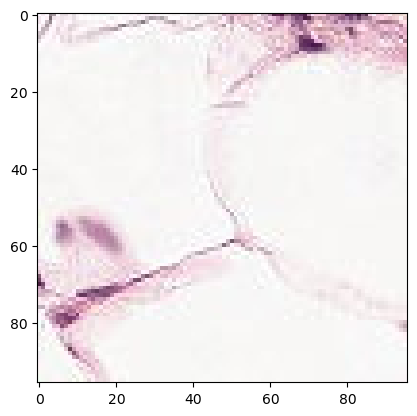

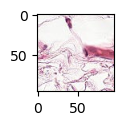

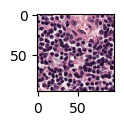

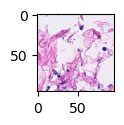

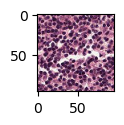

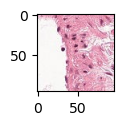

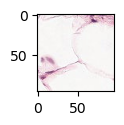

In [305]:
fig, ax = plt.subplots() 

print('Negative Image Examples:')

ind = 0
ct = 0

for path in df['Path']:
    if df['label'][ind] == 0:
        ct += 1
        plt.figure(figsize=(1,1))
        img = mpimg.imread(path)
        imgplot = plt.imshow(img)
        ax.imshow(img)
        
    if ct > 5:
        break;
        
    ind += 1

Positive Image Examples:


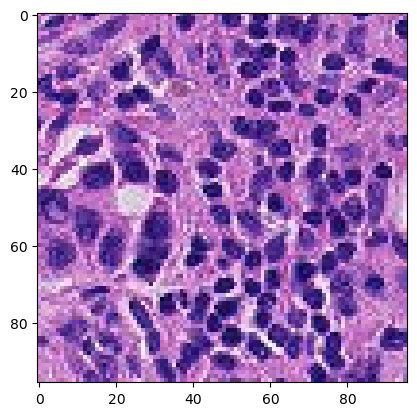

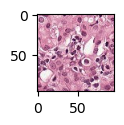

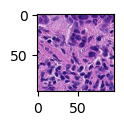

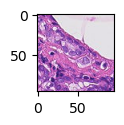

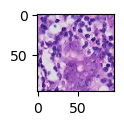

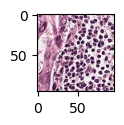

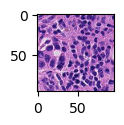

In [306]:
fig, ax = plt.subplots() 

print('Positive Image Examples:')

ind = 0
ct = 0

for path in df['Path']:
    if df['label'][ind] == 1:
        ct += 1
        plt.figure(figsize=(1,1))
        img = mpimg.imread(path)
        imgplot = plt.imshow(img)
        ax.imshow(img)
        
    if ct > 5:
        break;
        
    ind += 1

### Discussion

Observed __average brightness and RGB levels__ present in positive and negative cancer images.  Found negative examples to be slightly brighter and usually have higher RGB values.  In general, both positive and negative images had very very __similar average brightness/RGB levels.__  Plotted each value in __bar plots__ for comparison purposes.  Note: Only __10,000 training examples__ were used for these comparison purposes, as using the entire dataset would have taken a far longer amount of computing time.

In [ ]:
X = []
random_indices =  np.random.choice(df.shape[0], size=10000, replace=False)

for i, idx in enumerate(random_indices):
    X.append(cv2.imread(df.loc[idx, 'Path']))
    y.append(df.loc[idx,'label'])

X = np.array(X)
pos_samples = []
neg_samples = []

ind = 0
for pic in X:
    if y[ind] == 1:
        pos_samples.append(pic)
    else:
        neg_samples.append(pic)
    ind += 1

pos_samples = np.array(pos_samples)
neg_samples = np.array(neg_samples)

pos_sample_bright_avgs=np.mean(pos_samples[:,:,:,:])
pos_sample_red_avgs=np.mean(pos_samples[:,:,:,0])
pos_sample_green_avgs=np.mean(pos_samples[:,:,:,1])
pos_sample_blue_avgs=np.mean(pos_samples[:,:,:,2])

pos_avgs = [pos_sample_bright_avgs,pos_sample_red_avgs,pos_sample_green_avgs,pos_sample_blue_avgs]

neg_sample_bright_avgs=np.mean(neg_samples[:,:,:,:])
neg_sample_red_avgs=np.mean(neg_samples[:,:,:,0])
neg_sample_green_avgs=np.mean(neg_samples[:,:,:,1])
neg_sample_blue_avgs=np.mean(neg_samples[:,:,:,2])

neg_avgs = [neg_sample_bright_avgs,neg_sample_red_avgs,neg_sample_green_avgs,neg_sample_blue_avgs]

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\14436\AppData\Local\Temp\ipykernel_18108\3121793540.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if channel is "Brightness":


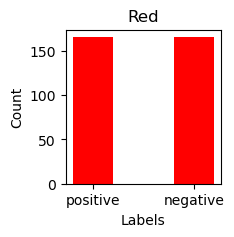

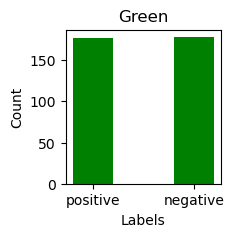

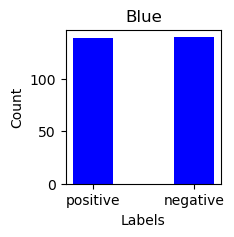

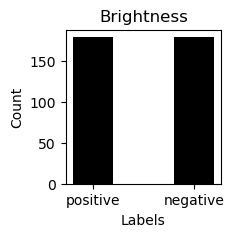

In [342]:
channels = ["Red", "Green", "Blue", "Brightness"]
samples = [pos_samples, neg_samples]

labs = ["positive","negative"]

for i,channel in enumerate(channels):
    fig = plt.figure(figsize = (2, 2))
    vals = [pos_avgs[i],neg_avgs[i]]
    
    if channel is "Brightness":
        c = "black"
    else:
        c = channel
        
    plt.bar(labs, vals, color =c,width = 0.4)

    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(channel)
    plt.show()

### Discussion

Observed __standard deviations for brightness and RGB levels__ present in positive and negative cancer images.  Found negative examples to be slightly more variant in brightness and RGB levels.  In general, both positive and negative images had very __similar standard deviations of brightness/RGB levels.__  Plotted each value in __bar plots__ for comparison purposes.  Note: Only __10,000 training examples__ were used for these comparison purposes, as using the entire dataset would have taken a far longer amount of computing time.

In [343]:
pos_sample_bright_stds=np.std(pos_samples[:,:,:,:])
pos_sample_red_stds=np.std(pos_samples[:,:,:,0])
pos_sample_green_stds=np.std(pos_samples[:,:,:,1])
pos_sample_blue_stds=np.std(pos_samples[:,:,:,2])

pos_stds = [pos_sample_bright_stds,pos_sample_red_stds,pos_sample_green_stds,pos_sample_blue_stds]

neg_sample_bright_stds=np.std(neg_samples[:,:,:,:])
neg_sample_red_stds=np.std(neg_samples[:,:,:,0])
neg_sample_green_stds=np.std(neg_samples[:,:,:,1])
neg_sample_blue_stds=np.std(neg_samples[:,:,:,2])

neg_stds = [neg_sample_bright_stds,neg_sample_red_stds,neg_sample_green_stds,neg_sample_blue_stds]

[65.40222635821857, 54.98026453965851, 71.47138003633576, 60.63762703977423]
[66.02387534569549, 55.350677633438224, 72.56310584125221, 61.239882130500554]


<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\14436\AppData\Local\Temp\ipykernel_18108\2028817016.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if channel is "Brightness":


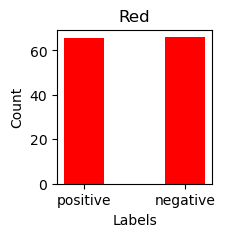

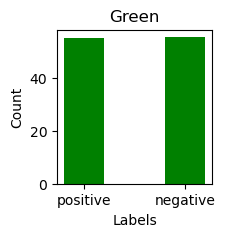

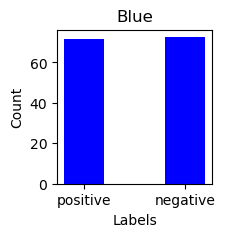

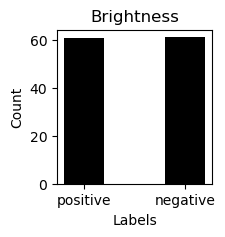

In [344]:
channels = ["Red", "Green", "Blue", "Brightness"]
samples = [pos_samples, neg_samples]

labs = ["positive","negative"]

for i,channel in enumerate(channels):
    fig = plt.figure(figsize = (2, 2))
    vals = [pos_stds[i],neg_stds[i]]
    
    if channel is "Brightness":
        c = "black"
    else:
        c = channel
        
    plt.bar(labs, vals, color =c,width = 0.4)

    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.title(channel)
    plt.show()

### Discussion

Plotted __histograms of brightness and RGB values__ for comparison purposes.  Even the histograms were very similar, proving that classification would be challenging.  Considering these histograms are so similar, a simple feature extraction method (such as histogram of gradients) would likely not be useful. There was __no clear baseline primitive feature (such as brightness)__ that could be easily used for classification.  Yet at the same time, from visual observation, it was clear that there were also __no high level objects__ that could be used for classification.  Instead, it appears that there must be __patterns of primitive features__ that can be extracted and used for classification. This __supports the use of convolutional neural network architecture.__

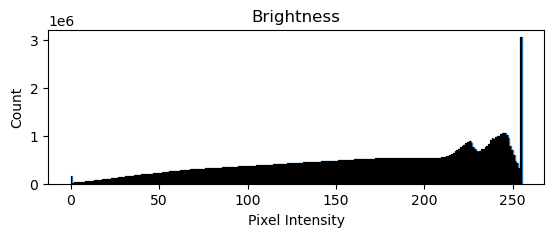

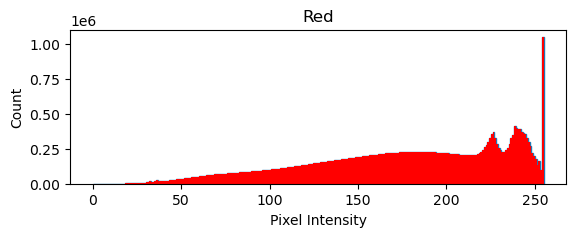

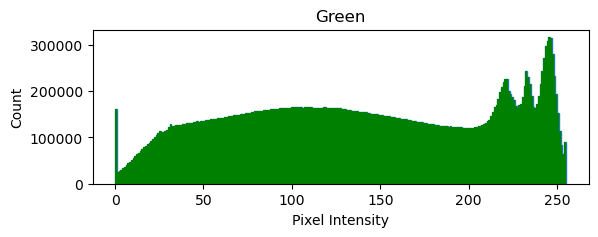

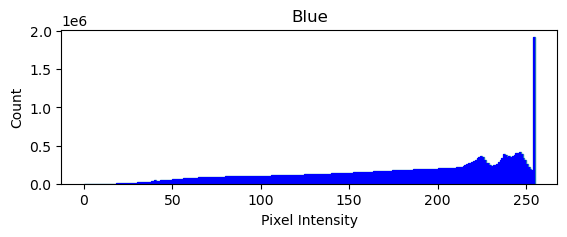

In [345]:
print("Positive Example Plots:")
counts, bins = np.histogram(pos_samples[:,:,:,:],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'black')

plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Brightness")
plt.show()

counts, bins = np.histogram(pos_samples[:,:,:,0],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'red')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Red")
plt.show()

counts, bins = np.histogram(pos_samples[:,:,:,1],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'green')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Green")
plt.show()

counts, bins = np.histogram(pos_samples[:,:,:,2],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Blue")
plt.show()

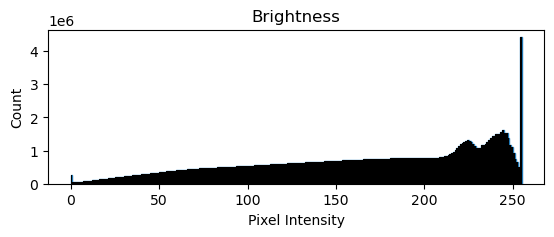

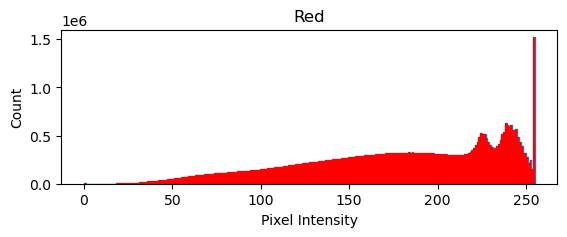

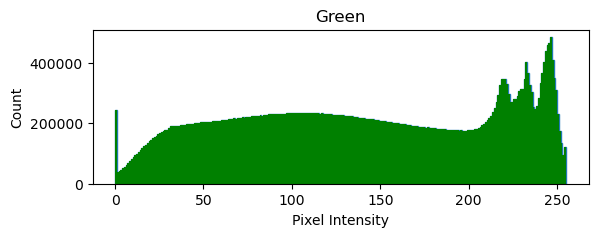

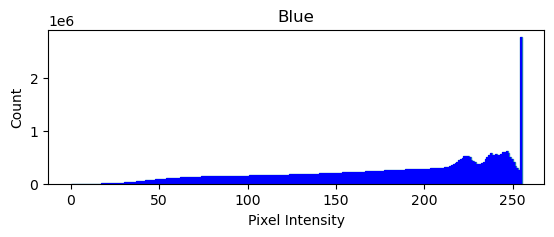

In [346]:
print("Negative Example Plots:")
counts, bins = np.histogram(neg_samples[:,:,:,:],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'black')

plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Brightness")
plt.show()

counts, bins = np.histogram(neg_samples[:,:,:,0],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'red')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Red")
plt.show()

counts, bins = np.histogram(neg_samples[:,:,:,1],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'green')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Green")
plt.show()

counts, bins = np.histogram(neg_samples[:,:,:,2],bins = 256)
plt.figure().set_figheight(2)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts,color = 'blue')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Blue")
plt.show()

### Discussion

The highly variant nature of the dataset certainly necessitates training and then validation before testing.  Thus the data was split into a training and validation set.

In [ ]:
# train test split
df_train, df_val = train_test_split(df, test_size=0.10, random_state=1)

### Discussion

Created working directory, train and val directories, and 1/0 classes within each in order to facilitate flow_from_directory training.

In [ ]:
def nukedir(dir):
    
    if dir[-1] == os.sep: dir = dir[:-1]
    fns = os.listdir(dir)
    
    for f in fns:
        if f == '.' or f == '..': continue
        p = dir + os.sep + f
        
        if os.p.isdir(p):
            nukedir(p)
        else:
            os.unlink(p)
            
    os.rmdir(dir)

# Erase workign directory. (very tough without nukedir function)
nukedir('working');
os.mkdir('working')

# Train working directory.
os.mkdir('working/train')
os.mkdir('working/train/1')
os.mkdir('working/train/0')

# Validate working directory.
os.mkdir('working/val')
os.mkdir('working/val/1')
os.mkdir('working/val/0')

### Discussion

Stored images in train/val.  Sorted positive and negative images into '1' and '0' directories, accordingly.

In [ ]:
for id in df_train['id'].values:
    fn = id +'.tif'
    n = df_train.loc[df_train['id'] == id]
    lab = str(n['label'].values[0])
    shutil.copyfile('train/' + fn,'working/train' + '/' + lab + '/' + fn)
    
for id in df_val['id'].values:
    fn = id +'.tif'
    n = df_val.loc[df_val['id'] == id]
    lab = str(n['label'].values[0])
    shutil.copyfile('train/' + fn,'working/val' + '/' + lab + '/' + fn)

## Part 2: Model Training

__Three convolutional neural networks__ were trained and their performance was recorded against the task of __histopathologic cancer detection in images of cell/cell membranes.__

The __first model__ was trained using transfer learning with the __base model being an untrainable version of InceptionV3.__  The model then used __two 2d convolutional layers with 3x3 kernels__ for final feature extraction and __two fully connected layers__ for classification.  The model also used a __2d convolutional layer with a 1x1 kernel__ after each of the two 3x3 kernel convolutional layers.  __Batch normalization__ was conducted after each 3x3 kernel convolutional layer and each fully connected layer.  The final convolutional layer was __flattened__ before being passed to the first fully connected layer.  The base model was 'cut' at the __layer mixed1.__  This layer was chosen due to its relatively __early stage in the architecture of InceptionV3.__  Going along with the hypothesis that __patterns of primitive features__ would ultimately be used to perform classification, only the beginning stages of InceptionV3 were needed (which might perform primitive feature extraction).  This was thought to be able to yield a __lighter weight model__ that still provided adequate, if not better information on primitive features to the next layers than the full InceptionV3 model or any more substantial chunk of it.  The output of mixed1 was then passed to the Conv2d layers for further feature extraction and finally to two dense layers for classification.  __Large numbers of filters and large dense layers were used__ in the custom portion of this model.  This was intentional and meant to try to __consider many different features__ within the images as potential candidates for use in classification.

The __second model__ was trained using transfer learning with the __base model being an untrainable version of Xception__, a later version of InceptionV3 thought to be more accurate under certain circumstances.  The custom portion of this model was built to be __lighter than the first model.__  A cascade of __three 2d convolutional layers__ was used each with 3x3 kernels.  Immediately after each of these layers a __2d convolutional layer with 1x1 kernel__ was implemented. A __single small fully connected layer__ was used for classification and just before it, the output of the convolutional layers was __flattened.__  __Batch normalization__ was used after each convolutional and dense layer. __ Xception was 'cut' at layer block3_pool.__  This is a layer at a relatively __early stage in Xception,__ and was utilized in the hopes that it would provide __primitive features at relatively low computational cost.__  The intention with a single fully connected layer was to try to build a light model on the assumption that collecting many patterns of primitive features, but down selecting only a small number of them for classification would yield an appropriate solution.

Finally, a __third custom model__ was developed.  This model was made __very lightweight,__ as training it without a base model proved to be very computationaly straining on my machine.  It contained a __single large 2d convolutional layer__ with a 3x3 kernel, which was followed by a convolutional layer of similar size with 1x1 kernels. A __max pooling layer__ with a very large focal region was then used to cut way down on the number of parameters before hitting a very __small fully connected layer.__  The intention here was, going along with what was stated before, there are likely many patterns of primitive features that need to be extracted.  However only a small number of them are probably relevant to classification.  They are also likely present throughout the images they are immersed within.  Thus, the __first convolutional layer extracts the primitive features, the max pooling layer groups them, and the small dense layer identifies which ones are actually appropriate.__ This yields a very small light weight architecture.

__Training__ was conducted with both the large batch size and small batch size __image data generators__ for the first model.  After positive results were confirmed with smaller batch sizes and more epochs (confirming the theory that the data set is highly variant), only the small batch size data generator was used for the second and third models. (Especially relevant for the third, which took quite a while to train).  __Flow from directory__ was used as converting the data into numpy arrays was far too computationally expensive.  Additionally, a __learning rate schedule__ was developed and adjusted early on for use throughout the training process for all models.

### Discussion

A __learning rate schedule__ was developed with an __exponential decay rate__ transformed into a __staircase.__  The number of steps was arbitrary and from an online source.  The initial learning rate and decay rate were adjusted once or twice and yielded better results for inception V3.  This was then carried over to training for the other two models.

In [257]:
init_lr = 0.01
steps = 1000
rate = 0.9 
lr_schedule = ExponentialDecay(init_lr, steps, rate, staircase=True)

### Discussion

__Image data generators were created.__  The image data generators __rescaled the inputs__ by normalizing them across the maximum value of 255 (pixel brightness/rgb value).  A __rotation range__ was applied to the images of 45 degrees.  The __width and height shifts__ were also adjusted by 50% and __vertical/horizontal flipping__ was turned on. These transformations were conducted across the training data set in order to tackle the inevitable problem of __variance across data__ that was apparent during the EDA procedure.

In [258]:
imDatGen = ImageDataGenerator(rescale=1./255,rotation_range = 45,width_shift_range=0.5,height_shift_range=0.5,vertical_flip=True,horizontal_flip=True,)
imDatGenVal = ImageDataGenerator(rescale=1./255,)

### Discussion

As described previously, __a large batch size with few epochs and small batch size with many epochs__ pair of image data generators were created.  It was theorized that the latter would end up performing better because smaller batch sizes would most likely be able to more effectively train models across __highly variant data.__

In [259]:
# Larger batches fewer epochs.
batch = 200
epochsLarge = 10
trainGenLarge=imDatGen.flow_from_directory(directory='working/train',batch_size=batch,color_mode='rgb',class_mode='binary',target_size=(96,96))
valGenLarge=imDatGenVal.flow_from_directory(directory='working/val', batch_size=batch,color_mode='rgb',class_mode='binary',target_size=(96,96))

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


In [260]:
# Smaller batches more epochs.
batch = 20
epochsSmall = 20
trainGenSmall=imDatGen.flow_from_directory(directory='working/train',batch_size=batch,color_mode='rgb',class_mode='binary',target_size=(96,96))
valGenSmall=imDatGenVal.flow_from_directory(directory='working/val', batch_size=batch,color_mode='rgb',class_mode='binary',target_size=(96,96))

Found 198022 images belonging to 2 classes.
Found 22003 images belonging to 2 classes.


### Discussion

The __first model__ was trained using transfer learning with the __base model being an untrainable version of InceptionV3.__ 

In [261]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model = Model(inputs = inception.input, outputs = inception.get_layer('mixed1').output)
base_model.trainable = False

model_heavy = Sequential([base_model,
    
    Conv2D(256, (3, 3), activation='relu'),BatchNormalization(),
    Conv2D(256, (1, 1),activation='relu'),BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),BatchNormalization(),            
    Conv2D(128, (1, 1), activation='relu'),BatchNormalization(),Flatten(),
                         
    Dense(128, activation='relu'),BatchNormalization(),
    Dense(24, activation='relu'),BatchNormalization(),
                         
    Dense(1, activation='sigmoid')
])

model_heavy.build(input_shape=(None, 96, 96, 3))
model_heavy.summary()
model_heavy.compile(optimizer=Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_168 (Functional)     │ (None, 9, 9, 288)      │       707,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1838 (Conv2D)            │ (None, 7, 7, 256)      │       663,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1821        │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1839 (Conv2D)            │ (None, 7, 7, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1822        │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1840 (Conv2D)            │ (None, 5, 5, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1823        │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1841 (Conv2D)            │ (None, 5, 5, 128)      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1824        │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_119 (Flatten)           │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1825        │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_285 (Dense)               │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1826        │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,165,089 (8.26 MB)

 Trainable params: 1,455,841 (5.55 MB)

 Non-trainable params: 709,248 (2.71 MB)

### Discussion

Trained with large batch sizes.

In [262]:
hist = model_heavy.fit(trainGenLarge,validation_data=valGenLarge,epochs=epochsLarge,steps_per_epoch=len(trainGenLarge),
                       validation_steps=len(valGenLarge),verbose=1)

Epoch 1/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 667s 666ms/step - accuracy: 0.8092 - loss: 0.4301 - val_accuracy: 0.7875 - val_loss: 0.5167
Epoch 2/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 667s 670ms/step - accuracy: 0.8555 - loss: 0.3427 - val_accuracy: 0.7739 - val_loss: 0.5778
Epoch 4/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 690s 693ms/step - accuracy: 0.8651 - loss: 0.3248 - val_accuracy: 0.8952 - val_loss: 0.2639
Epoch 6/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
991/991 ━━━━━━━━━━━━━━━━━━━━ 676s 679ms/step - accuracy: 0.8706 - loss: 0.3129 - val_accuracy: 0.8971 - val_loss: 0.2736
Epoch 8/10
991/991 ━━━━━━━━━━━━━━━━━━

### Discussion

Training with __smaller batch sizes produced superior results.__ (Almost 4% better validation accuracy).  This confirmed the theory that the data was highly variant.

In [263]:
hist2 = model_heavy.fit(trainGenSmall,validation_data=valGenSmall,epochs=epochsSmall,steps_per_epoch=len(trainGenSmall),
                       validation_steps=len(valGenSmall),verbose=1)

Epoch 1/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 836s 84ms/step - accuracy: 0.8389 - loss: 0.3805 - val_accuracy: 0.8931 - val_loss: 0.2913
Epoch 2/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 833s 84ms/step - accuracy: 0.8607 - loss: 0.3384 - val_accuracy: 0.9004 - val_loss: 0.3538
Epoch 4/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 837s 84ms/step - accuracy: 0.8695 - loss: 0.3210 - val_accuracy: 0.9038 - val_loss: 0.4635
Epoch 6/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 843s 85ms/step - accuracy: 0.8714 - loss: 0.3185 - val_accuracy: 0.9006 - val_loss: 0.5067
Epoch 8/20
9902/9902 ━━━━━━━━━

### Discussion

The __second model__ was trained using transfer learning with the __base model being an untrainable version of Xception__.

In [264]:
exception = Xception(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model = Model(inputs = exception.input, outputs = exception.get_layer('block3_pool').output)
base_model.trainable = False

model_lite = Sequential([base_model,
    
    Conv2D(96, (2, 2), activation='relu'),BatchNormalization(),
    Conv2D(96, (1, 1), activation='relu'),BatchNormalization(),
                          
    Conv2D(64, (2, 2), activation='relu'),BatchNormalization(),
    Conv2D(64, (1, 1), activation='relu'),BatchNormalization(),
    
    Conv2D(32, (2, 2), activation='relu'),BatchNormalization(),
    Conv2D(32, (1, 1), activation='relu'),BatchNormalization(),Flatten(),
                          
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lite.build(input_shape=(None, 96, 96, 3))
model_lite.summary()
model_lite.compile(optimizer=Adam(learning_rate=lr_schedule),loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_171 (Functional)     │ (None, 12, 12, 256)    │       159,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1846 (Conv2D)            │ (None, 11, 11, 96)     │        98,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1831        │ (None, 11, 11, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1847 (Conv2D)            │ (None, 11, 11, 96)     │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1832        │ (None, 11, 11, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1848 (Conv2D)            │ (None, 10, 10, 64)     │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1833        │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1849 (Conv2D)            │ (None, 10, 10, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1834        │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1850 (Conv2D)            │ (None, 9, 9, 32)       │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1835        │ (None, 9, 9, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1851 (Conv2D)            │ (None, 9, 9, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1836        │ (None, 9, 9, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_120 (Flatten)           │ (None, 2592)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 24)             │        62,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,105 (1.41 MB)

 Trainable params: 208,817 (815.69 KB)

 Non-trainable params: 160,288 (626.12 KB)

### Discussion

Trained with smaller batch sizes.

In [265]:
hist3 = model_lite.fit(trainGenSmall,validation_data=valGenSmall,epochs=epochsSmall,steps_per_epoch=len(trainGenSmall),
                       validation_steps=len(valGenSmall),verbose=1)

Epoch 1/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 926s 93ms/step - accuracy: 0.7928 - loss: 0.4639 - val_accuracy: 0.7614 - val_loss: 0.5906
Epoch 2/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 933s 94ms/step - accuracy: 0.8453 - loss: 0.3645 - val_accuracy: 0.8860 - val_loss: 0.2854
Epoch 4/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 1504s 152ms/step - accuracy: 0.8625 - loss: 0.3329 - val_accuracy: 0.8720 - val_loss: 0.3276
Epoch 6/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 976s 98ms/step - accuracy: 0.8673 - loss: 0.3205 - val_accuracy: 0.8763 - val_loss: 0.3037
Epoch 8/20
9902/9902 ━━━━━━━

### Discussion

Finally, a __third custom model__ was developed.  This model was made __very lightweight,__ as training it without a base model proved to be very computationally straining on my machine.

In [280]:
model_custom = Sequential([
    
    Conv2D(256, (3, 3), activation='relu'),BatchNormalization(),
    Conv2D(256, (1, 1),activation='relu'),BatchNormalization(),
                    
    MaxPooling2D(pool_size=(10, 10)),BatchNormalization(),Flatten(),
    
    Dense(4, activation='relu'),BatchNormalization(),

    Dense(1, activation='sigmoid')
])

model_custom.build(input_shape=(None, 96, 96, 3))
model_custom.summary()
model_custom.compile(optimizer=Adam(learning_rate=0.000001),loss='binary_crossentropy',metrics=['accuracy'])

Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1866 (Conv2D)            │ (None, 94, 94, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1865        │ (None, 94, 94, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1867 (Conv2D)            │ (None, 94, 94, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1866        │ (None, 94, 94, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1867        │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_128 (Flatten)           │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 4)              │        82,948 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1868        │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,001 (621.10 KB)

 Trainable params: 157,457 (615.07 KB)

 Non-trainable params: 1,544 (6.03 KB)

### Discussion

I attempted to train the smaller custom model, but it turned out that it would take almost an entire day of training.  The other models were must faster to train because as we can see transfer learning allowed them to take advantage of very large initial layers in the pretrained models.  The first layer of the small custom model's dimensions are (94,94,256).  The first layer of the custom portion of the second model (as an example) is only (11,11,96).  This makes a huge difference when training especially with subsequent massive layers.  As a result, I decided not to try to train my custom model.

In [281]:
# hist4 = model_custom1.fit(trainGenSmall,validation_data=valGenSmall,epochs=epochsSmall,steps_per_epoch=len(trainGenSmall),
#                        validation_steps=len(valGenSmall),verbose=1)

## Part 3: Conclusion


As a result of my efforts, the first model trained with small batches and lots of epochs performed best against validation data.  It achieved a validation accuracy of around 90.5%.  This beat the second model build off of Xception, which achieved a validation accuracy of 88.8%.

Unfortunately, for some reason my model_heavy based on InceptionV3 was not running for submission, so I used my model_lite with Xception as a base model...

I will now run the second model against the test data.

In [292]:
test_dir = 'test'
pathList = []
nameList = []

for filename in os.listdir(test_dir):
    f = os.path.join(test_dir, filename)
    if os.path.isfile(f):
        nameList.append(filename.split('.')[0])
        pathList.append(test_dir + '/' + filename)

df_test = pd.DataFrame(data={'Path': pathList, 'id': nameList})

df_test.head()

,Path,id
0,test/00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,test/000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [305]:
print(len(df_test['Path']))

57458


In [311]:
predictions = []

for path in df_test['Path']:
    image = keras.utils.load_img(path)
    input_arr = keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions.append(model_lite.predict(input_arr,verbose = 0)[0][0])

In [338]:
preds = []

for pred in predictions:
    if pred > 0.5:
        preds.append(1)
    else:
        preds.append(0)

print(sum(preds))

1749


In [334]:
data = {"label":preds}

df_test.insert(1,"label",preds,True)
df_test.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,0
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0


In [337]:
df_test.to_csv('submission.csv', index=False)

In [354]:
predictions = []
ind = 0

for path in df['Path']:
    image = keras.utils.load_img(path)
    input_arr = keras.utils.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions.append(model_lite.predict(input_arr,verbose = 0)[0][0])
    ind += 1
    if ind > 1000:
        break

In [355]:
preds = []

for pred in predictions:
    if pred > 0.5:
        preds.append(1)
    else:
        preds.append(0)

print(sum(preds))
print(sum(df['label'][0:1001]))

25
377


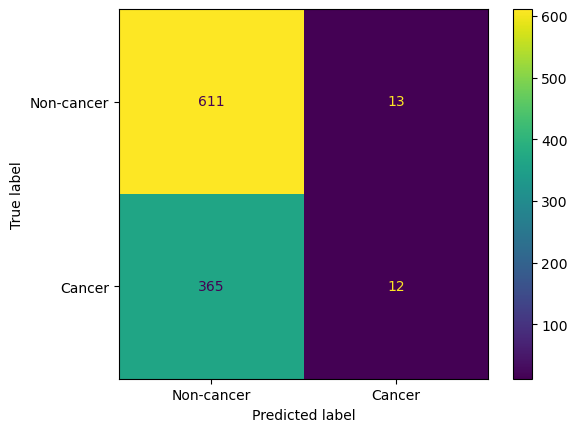

In [356]:
cm = confusion_matrix(df['label'][0:1001], preds)

cm_display = ConfusionMatrixDisplay(cm,display_labels=['Non-cancer', 'Cancer']).plot()

## References:

https://stackoverflow.com/questions/13766513/how-to-do-force-remove-in-python-like-rm-rf-on-linux

https://www.kaggle.com/code/jieshends2020/cnn-cancer-detection-inceptiontransferlearning